In [1]:
! pip install python-Levenshtein
! pip install editdistance

In [2]:
import json
import ast
import pandas as pd
import numpy as np
import editdistance
import Levenshtein as lev
from sklearn.metrics import jaccard_score
from ast import literal_eval

In [3]:
# load files
with open('/Users/xuenichen/Desktop/Process_Mining_1-main/data/trace_predictions_BPI_Challenge_2017.json', 'r') as f:
    predicted_traces = json.load(f)

with open('/Users/xuenichen/Desktop/Process_Mining_1-main/data/traces_BPI_Challenge_2017.json', 'r') as f:
    actual_traces = json.load(f)

In [4]:
# for matching 1000 'case:concept:name'
matched_traces = []

for pred_trace in predicted_traces:
    case_name = pred_trace['case:concept:name']
    actual_trace = next(
        (trace for trace in actual_traces if trace['case:concept:name'] == case_name), None)
    if actual_trace:
        matched_traces.append({
            'case:concept:name': case_name,
            'predicted_traces': pred_trace['predicted_traces'],
            'trace': actual_trace['trace']
        })

In [5]:
results_df = pd.DataFrame(matched_traces)
results_df.to_csv(
    '/Users/xuenichen/Desktop/Process_Mining_1-main/data/matched_traces.csv', index=False)

In [6]:
df = pd.read_csv(
    '/Users/xuenichen/Desktop/Process_Mining_1-main/data/matched_traces.csv')

In [7]:
print(df.head(2))

       case:concept:name                                   predicted_traces  \
0  Application_939104505  [{'concept:name': 'A_Create Application', 'tim...   
1  Application_939229827  [{'concept:name': 'A_Create Application', 'tim...   

                                               trace  
0  [{'concept:name': 'A_Create Application', 'tim...  
1  [{'concept:name': 'A_Create Application', 'tim...  


In [8]:
def extract_events(trace_list):
    try:
        trace_list_evaluated = literal_eval(
            trace_list) if isinstance(trace_list, str) else trace_list
        return [event['concept:name'] for event in trace_list_evaluated]
    except (ValueError, SyntaxError):
        # In case of any error during conversion, return an empty list or handle as needed
        print(f"Error processing trace: {trace_list}")
        return []


# Function to calculate the Jaccard Similarity for two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

In [9]:
# Initialize lists to hold the metrics for each trace pair
edit_distances = []
jaccard_similarities = []

# Loop through each row and calculate metrics
for _, row in df.iterrows():
    predicted_events = extract_events(row['predicted_traces'])
    actual_events = extract_events(row['trace'])

    # Calculate the edit distance for this pair of traces
    distance = editdistance.eval(predicted_events, actual_events)
    edit_distances.append(distance)

    # Calculate the Jaccard similarity for this pair of traces
    similarity = jaccard_similarity(set(predicted_events), set(actual_events))
    jaccard_similarities.append(similarity)

In [10]:
# Calculate the mean of the edit distances and Jaccard similarities
mean_edit_distance = np.mean(edit_distances)
mean_jaccard_similarity = np.mean(jaccard_similarities)

# Print the list of edit distances for each pair of traces
print("List of Edit Distances for each pair of traces:")
print(edit_distances)

# Print the list of Jaccard similarities for each pair of traces
print(" \nList of Jaccard Similarities for each pair of traces:")
print(jaccard_similarities)

# Print the mean edit distance for the entire dataset
print(f" Mean Edit Distance for the entire dataset: {mean_edit_distance}")

# Print the mean Jaccard similarity for the entire dataset
print(f" Mean Jaccard Similarity for the entire dataset: {mean_jaccard_similarity}")

List of Edit Distances for each pair of traces:
[75, 59, 76, 72, 58, 77, 72, 75, 75, 76, 78, 71, 74, 66, 67, 74, 70, 64, 69, 40, 48, 78, 65, 75, 65, 60, 71, 71, 76, 64, 58, 78, 71, 63, 76, 77, 77, 75, 77, 67, 75, 70, 77, 73, 72, 65, 73, 72, 55, 63, 53, 57, 67, 74, 75, 73, 77, 48, 66, 78, 76, 63, 74, 75, 68, 67, 70, 76, 73, 73, 74, 74, 78, 69, 62, 77, 75, 73, 78, 46, 70, 75, 74, 74, 58, 74, 72, 55, 76, 70, 75, 74, 75, 76, 66, 63, 75, 77, 67, 76, 51, 75, 77, 61, 78, 72, 71, 72, 72, 76, 70, 70, 73, 61, 75, 72, 77, 66, 58, 74, 64, 71, 62, 73, 67, 65, 72, 86, 73, 62, 75, 72, 72, 77, 77, 74, 75, 71, 64, 58, 59, 77, 61, 73, 77, 68, 57, 66, 70, 66, 71, 57, 73, 67, 63, 76, 72, 70, 75, 54, 68, 77, 77, 76, 74, 74, 72, 64, 78, 71, 75, 56, 69, 78, 76, 70, 61, 78, 57, 71, 62, 72, 65, 68, 73, 79, 73, 59, 75, 55, 78, 74, 74, 73, 46, 38, 56, 70, 56, 62, 54, 60, 74, 49, 69, 73, 70, 59, 72, 74, 73, 77, 75, 42, 76, 70, 78, 69, 52, 73, 66, 77, 62, 76, 63, 76, 70, 60, 63, 70, 74, 44, 73, 75, 66, 71, 70, 78,

In [11]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer


# Assuming the DataFrame is loaded from a CSV file:
df = pd.read_csv('/Users/xuenichen/Desktop/Process_Mining_1-main/Sprint_3/matched_traces.csv',
                 converters={'predicted_traces': literal_eval, 'trace': literal_eval})

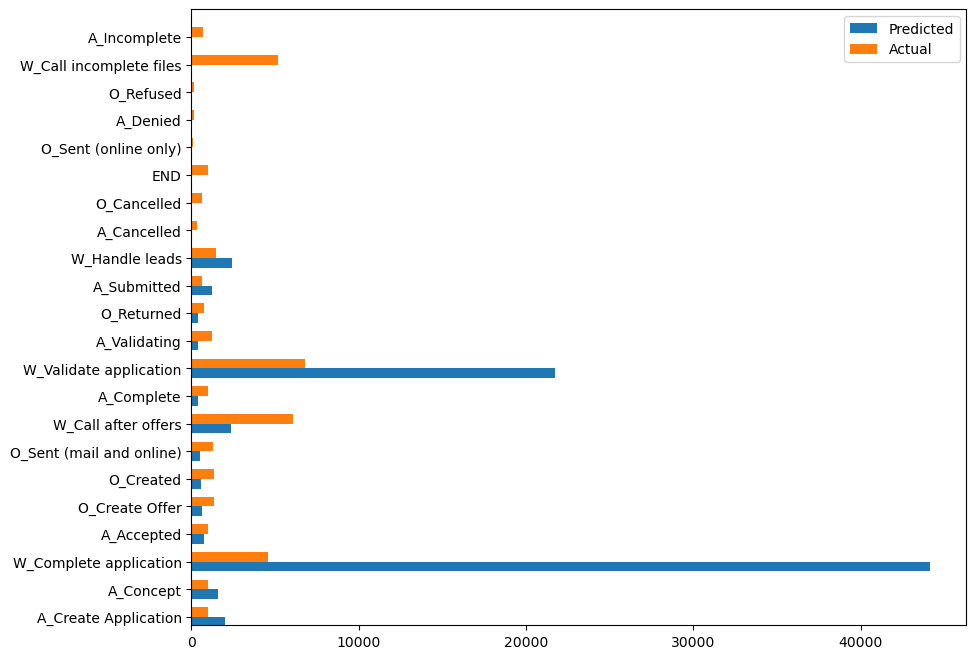

In [12]:
# Define a function to extract events from the serialized lists
def extract_events(serialized_list):
    return [event['concept:name'] for event in serialized_list]


# Apply this function to your columns to create the 'predicted_events' and 'actual_events' columns
df['predicted_events'] = df['predicted_traces'].apply(extract_events)
df['actual_events'] = df['trace'].apply(extract_events)

# Flatten the lists to count the frequency of each event
predicted_flattened = [
    event for sublist in df['predicted_events'] for event in sublist]
actual_flattened = [event for sublist in df['actual_events']
                    for event in sublist]

predicted_counts = Counter(predicted_flattened)
actual_counts = Counter(actual_flattened)

# Convert counters to dataframes
predicted_df = pd.DataFrame(predicted_counts.items(), columns=[
                            'Event', 'Predicted Frequency'])
actual_df = pd.DataFrame(actual_counts.items(), columns=[
                         'Event', 'Actual Frequency'])

# Merge on Event
merged_df = pd.merge(predicted_df, actual_df, on='Event')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.35  # bar width
ind = np.arange(len(merged_df))  # the x locations for the groups

ax.barh(ind - width/2,
        merged_df['Predicted Frequency'], width, label='Predicted')
ax.barh(ind + width/2, merged_df['Actual Frequency'], width, label='Actual')

ax.set(yticks=ind, yticklabels=merged_df['Event'], ylim=[
       2*width - 1, len(merged_df)])
ax.legend()

plt.show()

In [13]:
def create_sankey_df(events_list):
    source, target, value = [], [], []
    for trace in events_list:
        for i in range(len(trace)-1):
            if (trace[i], trace[i+1]) not in list(zip(source, target)):
                source.append(trace[i])
                target.append(trace[i+1])
                value.append(1)
            else:
                idx = list(zip(source, target)).index((trace[i], trace[i+1]))
                value[idx] += 1
    return pd.DataFrame({'source': source, 'target': target, 'value': value})


# Create DataFrames for predicted and actual events
predicted_sankey = create_sankey_df(df['predicted_events'])
actual_sankey = create_sankey_df(df['actual_events'])

# Generate a list of all unique events
all_events = list(set(predicted_sankey['source'].tolist() + predicted_sankey['target'].tolist(
) + actual_sankey['source'].tolist() + actual_sankey['target'].tolist()))
event_dict = {event: i for i, event in enumerate(all_events)}

# Map events to integers
predicted_sankey.replace(event_dict, inplace=True)
actual_sankey.replace(event_dict, inplace=True)

# Plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_events,
    ),
    link=dict(
        source=predicted_sankey['source'],
        target=predicted_sankey['target'],
        value=predicted_sankey['value'],
        color="blue"
    ))])

fig.update_layout(title_text="Predicted Trace Flows", font_size=10)
fig.show()

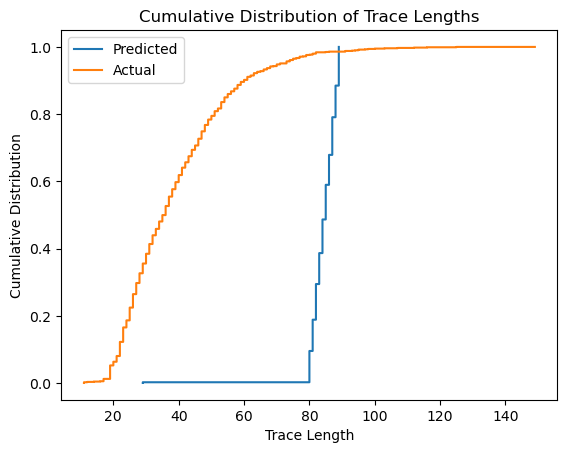

In [14]:
predicted_lengths = df['predicted_events'].apply(len)
actual_lengths = df['actual_events'].apply(len)

plt.step(sorted(predicted_lengths), np.arange(
    1, len(predicted_lengths) + 1) / len(predicted_lengths), label='Predicted')
plt.step(sorted(actual_lengths), np.arange(
    1, len(actual_lengths) + 1) / len(actual_lengths), label='Actual')

plt.xlabel('Trace Length')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Trace Lengths')
plt.legend()
plt.show()

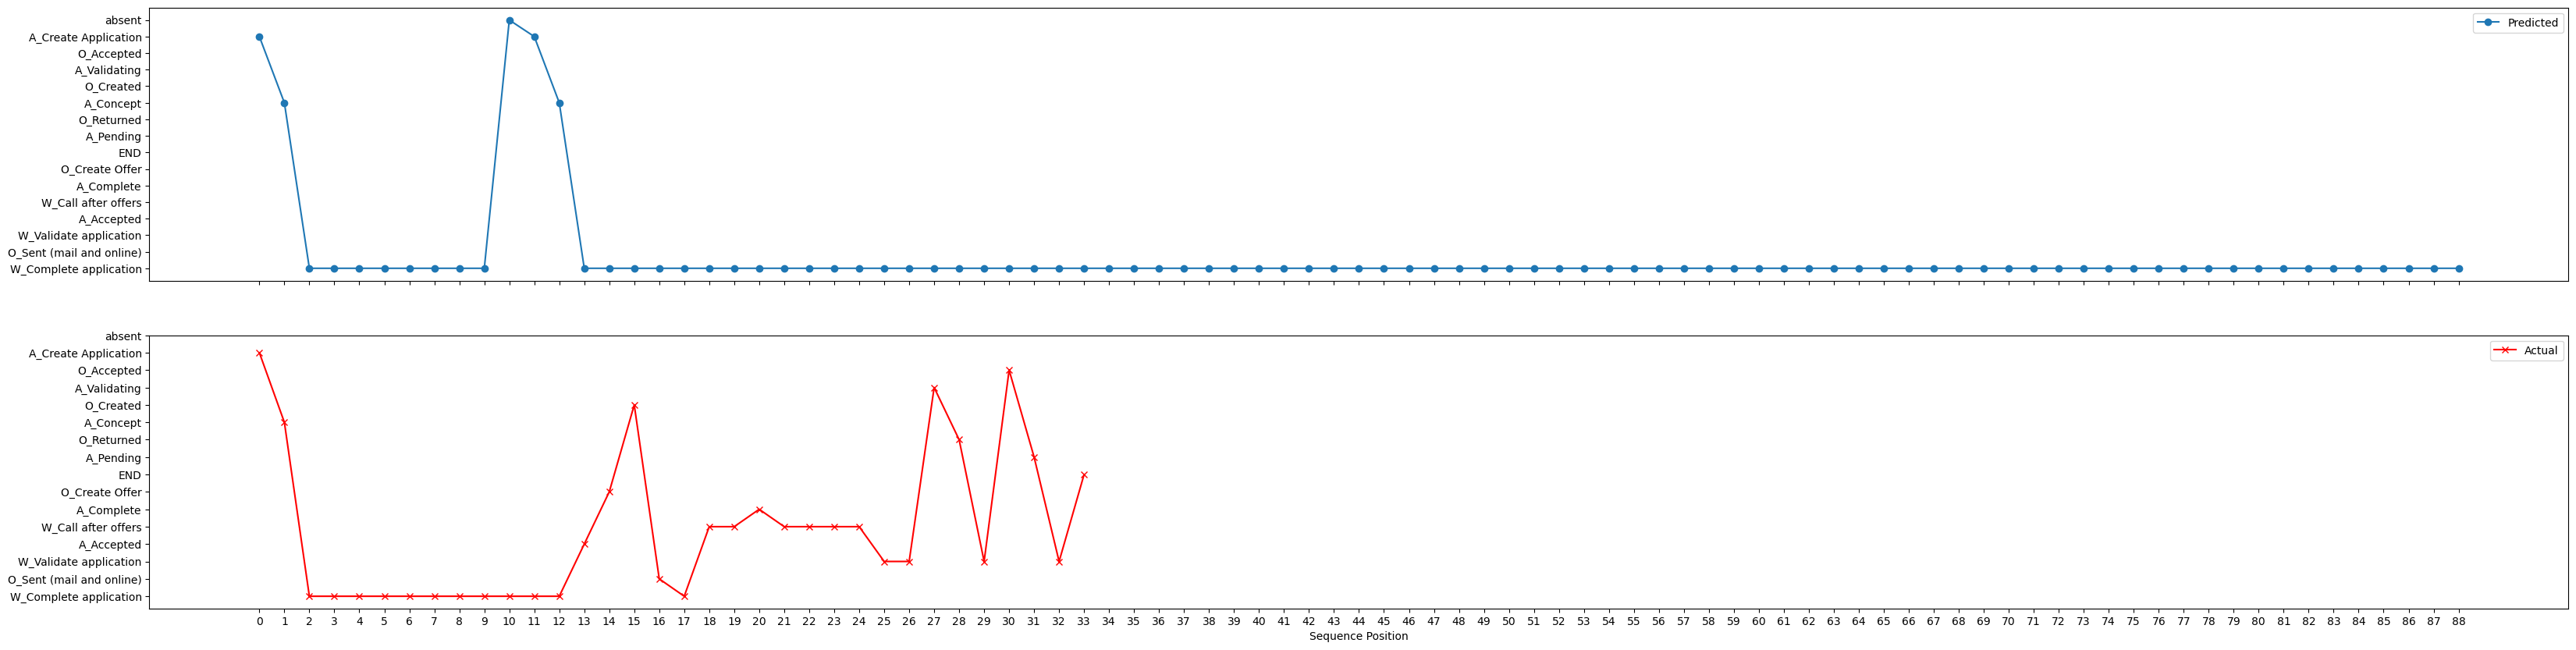

In [15]:
pred_seq = df['predicted_events'].iloc[0]
act_seq = df['actual_events'].iloc[0]

# Creating a figure and axis for plotting
fig, ax = plt.subplots(2, 1, figsize=(40, 10), sharex=True)

# Defining a simple mapping from event names to integers
event_set = set(pred_seq + act_seq)
event_map = {event: i for i, event in enumerate(event_set)}

# Mapping events to integers for plotting
mapped_pred_seq = [event_map[event] for event in pred_seq]
mapped_act_seq = [event_map[event] for event in act_seq]

# Plotting
ax[0].plot(mapped_pred_seq, marker='o', label='Predicted')
ax[0].set_yticks(np.arange(len(event_set)))
ax[0].set_yticklabels(event_map.keys())
ax[0].legend()

ax[1].plot(mapped_act_seq, marker='x', label='Actual', color='r')
ax[1].set_yticks(np.arange(len(event_set)))
ax[1].set_yticklabels(event_map.keys())
ax[1].legend()

plt.xticks(range(max(len(pred_seq), len(act_seq))))
plt.xlabel('Sequence Position')
plt.show()

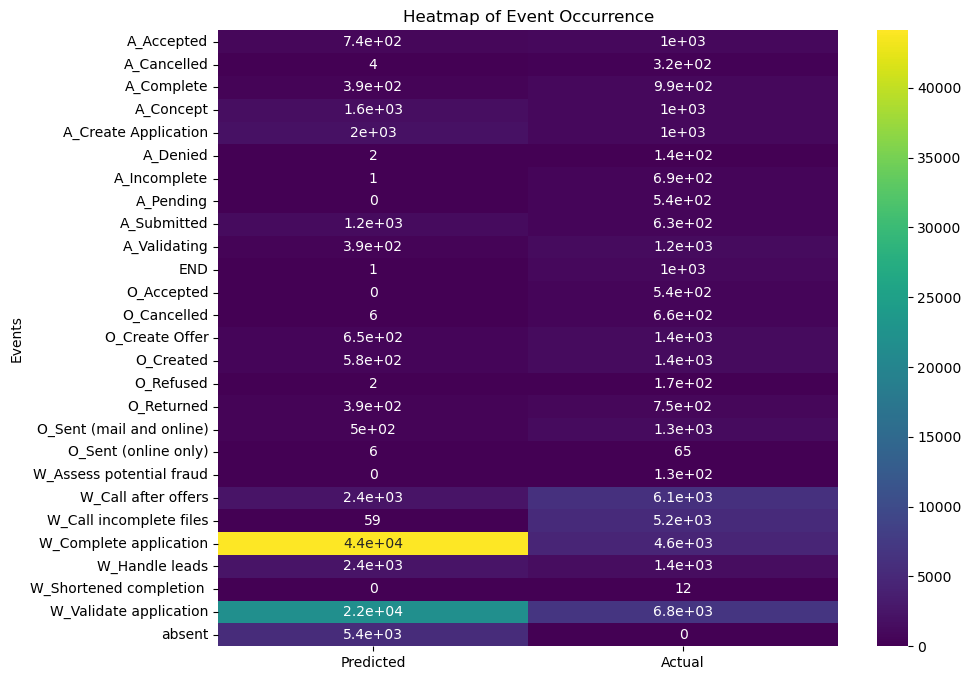

In [16]:
# Flattening the lists of events for all sequences
all_pred_events = [event for sublist in df['predicted_events']
                   for event in sublist]
all_act_events = [event for sublist in df['actual_events']
                  for event in sublist]

# Counting occurrences
pred_counts = Counter(all_pred_events)
act_counts = Counter(all_act_events)

# Converting to DataFrame for plotting
pred_df = pd.DataFrame.from_dict(
    pred_counts, orient='index', columns=['Predicted'])
act_df = pd.DataFrame.from_dict(act_counts, orient='index', columns=['Actual'])

# Merging the counts
event_df = pred_df.merge(act_df, left_index=True,
                         right_index=True, how='outer').fillna(0)

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(event_df, annot=True, cmap='viridis')
plt.title('Heatmap of Event Occurrence')
plt.ylabel('Events')
plt.show()

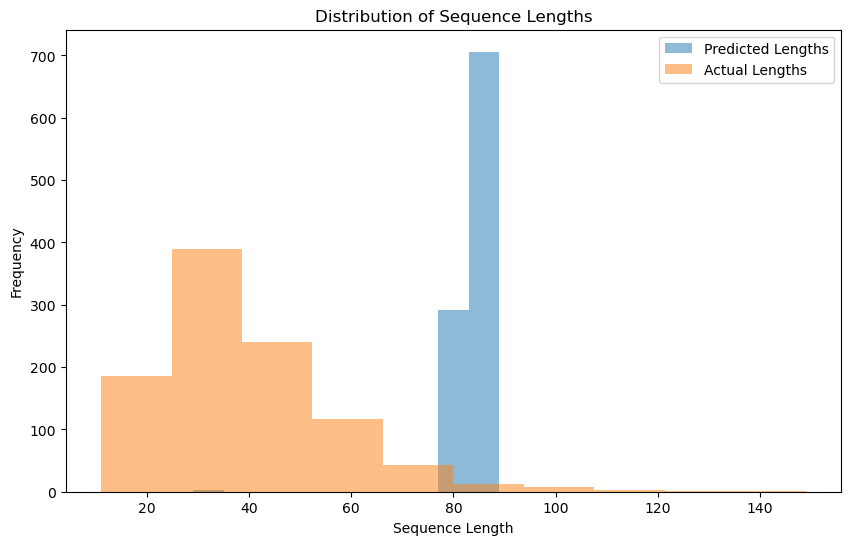

In [17]:
pred_lengths = df['predicted_events'].apply(len)
act_lengths = df['actual_events'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(pred_lengths, alpha=0.5, label='Predicted Lengths')
plt.hist(act_lengths, alpha=0.5, label='Actual Lengths')
plt.legend()
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()